# Analysis and Time Series Forecasting of Energy Consumption

This report contains descriptive analytics and univariate time series forecasting of the [Household Power Consumption Dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption). This dataset describes electricity consumption for a single household over four years, including energy measurements taken for every minute between 12-16-2006 and 12-11-2010.


## Goals

The focus of this analysis will be on **global_active_power:** the total active power consumed by the household (kilowatts).

### Visualization
* Perform descriptive analytics on the global_active_power variable
* Plot time series of global_active_power over the entire four year timeframe
* Plot average monthly global active power
* Plot typical daily consumption by month
* Plot global active power 

### Forecasting 
Apply and evaluate the following forecasting methods to the global_active_power time series:
* Linear Regression (perfomed only as an exercise - not applicable to this dataset)
* Seasonal AutoRegressive Integrated Moving Average (SARINA)
* Prophet Forecasting Procedure

## Get Data

The following libraries will be used for dataframes, visualization, and machine learning.

In [8]:
import config as config

In [13]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py #pip install plotly
import plotly.graph_objs as go
from scipy import stats
from fbprophet import Prophet #pip install fbprophet
import warnings
warnings.filterwarnings('ignore')
py.tools.set_credentials_file(username=config.plotly['username'], api_key=config.plotly['api_key'])

The household_power_consumption file was quite large, so I stored it in my github repository using Large File Storage (LFS). The next step is to assign data types to each variable within the dataset. Approximately 1% of the dataset has missing values, so this is addressed with a forward fill.

In [14]:
#Import data file
path = 'https://media.githubusercontent.com/media/mkivenson/Household-Power-Consumption/master/household_power_consumption.txt'

dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
energy = pd.read_csv(path, sep=';',dtype=dtypes, na_values="?")
energy = energy.fillna(method='ffill')

Some additional data preparation steps include adding a datetime formatted column as well as the following time summary columns: Year, Month, Day, and Hour. Finally, unnecessary columns are removed from the dataset. Now that the preliminary cleanup is complete, we can take a preview of the resulting dataframe below.

In [15]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,16/12/2006,2006,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,16/12/2006,2006,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,16/12/2006,2006,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,16/12/2006,2006,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,16/12/2006,2006,12,5,17,17:28:00,3.666


## Explore and Visualize Series

### Descriptive Analysis

This section will provide an overview of the Global_active_power distribution and how it behaves over time.

**Distributions**

First, we can summarize at the variable of interest, Global_active_power. Based on the mean (1.09) and median (0.6) values shown in the variable description, it appears that the power consumption is strongly left skewed. We can take a closer look at the distribution of this variable by plotting a histogram and a boxplot.

In [16]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

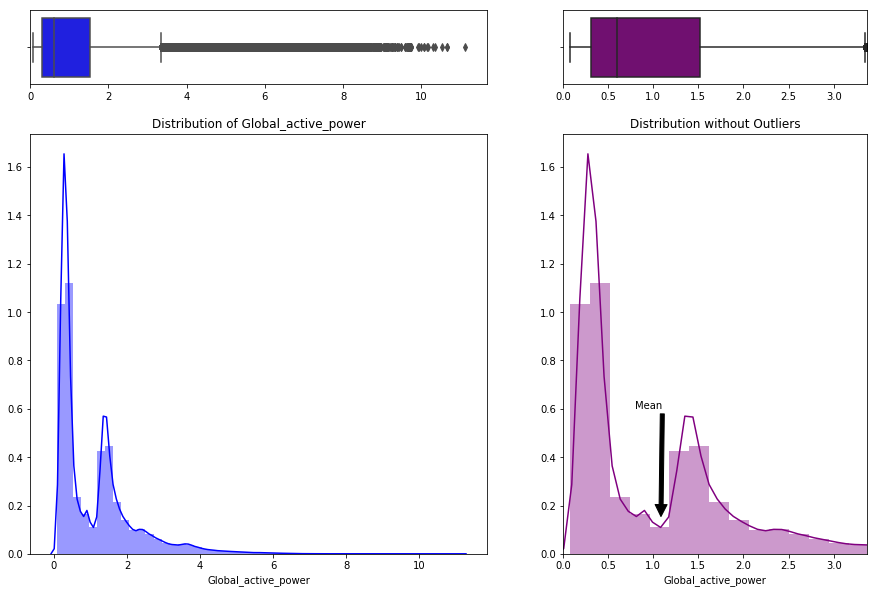

In [17]:
# Create subplots
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Main boxplot
sns.boxplot(energy["Global_active_power"] , color="blue", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Main distribution
sns.distplot(energy["Global_active_power"] , color="blue", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power')

#Zoom boxplot
sns.boxplot(energy["Global_active_power"], color="purple", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

#Zoom distribution
sns.distplot(energy["Global_active_power"], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribution without Outliers')
axes[1,1].set_xlim(0, 3.37)

# Add an arrow to mark the mean value
axes[1,1].annotate(
'Mean', xy=(energy["Global_active_power"].mean(), .15), xytext=(.8, .6),
arrowprops=dict(facecolor='black', shrink=0.01))

plt.show()

**Barplot Monthly Summary**

To begin understanding how Global_active_power changes over time, the plots below show mean, median, and peak demand for each month/year time period. It is evident that Global_active_power is seasonal; its values decrease in the summer months and rise in the winter months for all years. Between years, it appears that variation throughout the years is limited.

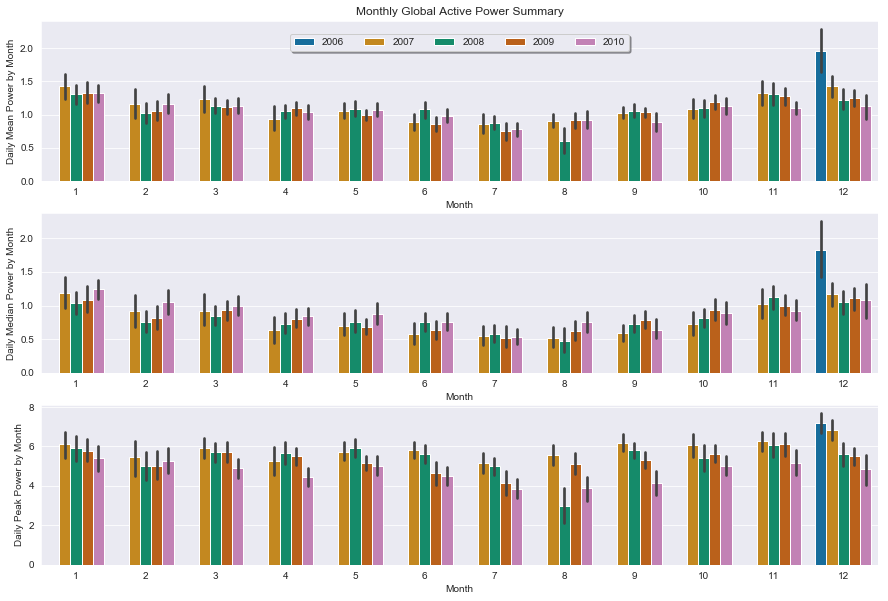

In [18]:
# Summarize power by month (mean, median, max)
energy_monthly_summary = energy.groupby(
    by=['Year','Month','Date'],
    as_index=False).agg({'Global_active_power':{'mean_active_power': 'mean', 
                                                'median_active_power': 'median', 
                                                'max_active_power': 'max'}})

# Create subplots
sns.set_style("darkgrid")
f, axes = plt.subplots(3, figsize=(15, 10), sharex=False)

# Monthly Mean subplot
mean = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.mean_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[0])
mean.set_title('Monthly Global Active Power Summary')
mean.set_ylabel('Daily Mean Power by Month')
mean.legend_.remove()

# Monthly Median subplot
median = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.median_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[1])
median.legend_.remove()
median.set_ylabel('Daily Median Power by Month')

# Monthly Peak subplot
max = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.max_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[2])
max.set_ylabel('Daily Peak Power by Month')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.35), shadow=True, ncol=5)

**Boxplot Weekday Summary**

The plots below show boxplots of mean Global_active_power for each day, faceted by year. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. At a glance, we can make the following observations:

*Median*
* 2007: Median power values were slightly higher on weekends
* 2008: Median power had the lowest value on Monday and the highest on Sunday
* 2009: Median power peaked on Saturday.
* 2010: Median power values were nearly constant across days

*Variance*
* 2007: variance (determined by interquartile range) was highest on Thursdays and Fridays
* 2008: variance was highest on Sundays and especially low on Fridays
* 2009: variance was low for most days, but was highest on Wednesdays and Saturdays
* 2010: variance was highest for Saturdays and very low for Fridays

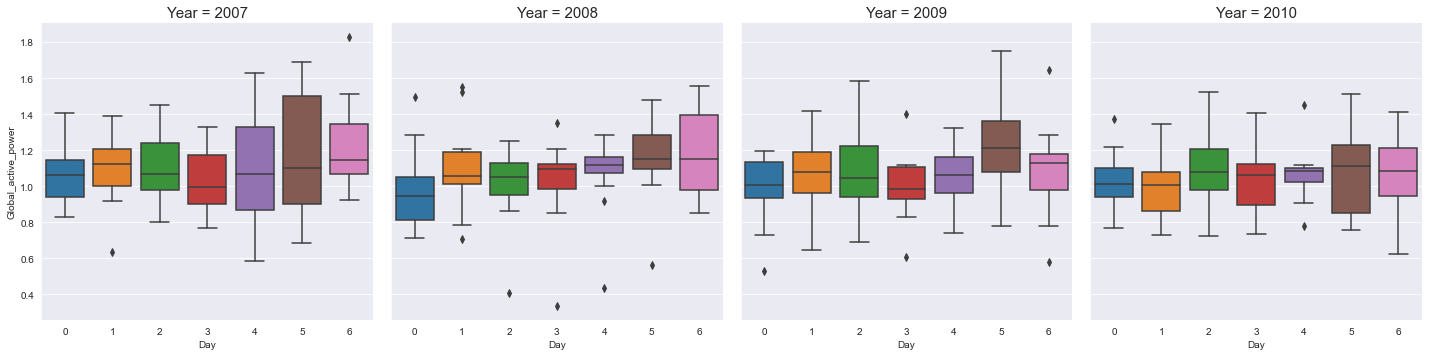

In [19]:
energy_weekday_summary = energy.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="box",
           col="Year")
day_plot.set_titles(size = 15)


**Barplot Hourly Summary**

For a more granular view of power consumption, the plots below summarize consumption by hour for each year. It is evident that the consumption sees two peaks during each day at 7:00 and 21:00; these daily peak times remain constant for each year.

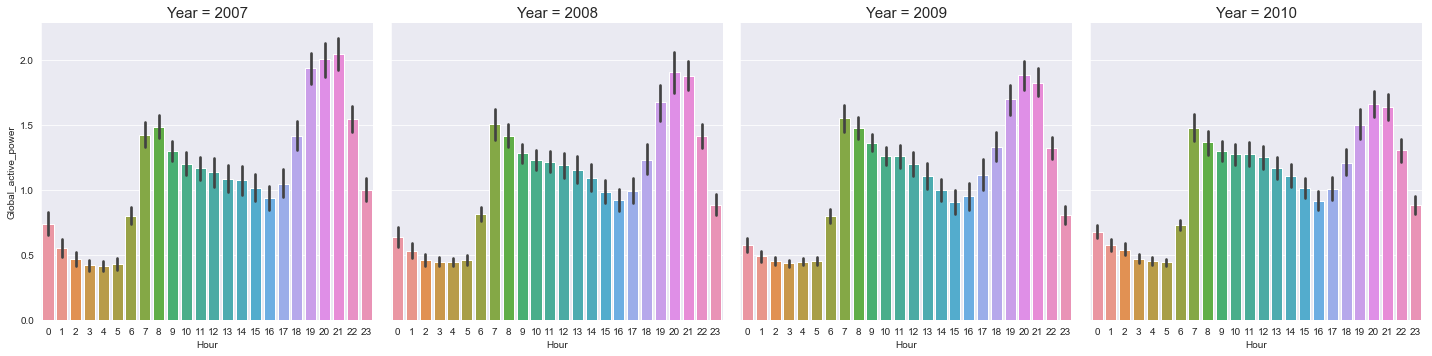

In [20]:
energy_hourly_summary = energy.groupby(by=['Year','Month','Day','Hour'], 
                                       as_index=False)[['Global_active_power']].mean()

hour_plot = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Year")
hour_plot.set_titles(size = 15)

**What about hourly average power by month?** 

We saw that across years, daily average power remains somewhat constant. The plot below shows that although the peaks remain the same, there is some variation between months. 

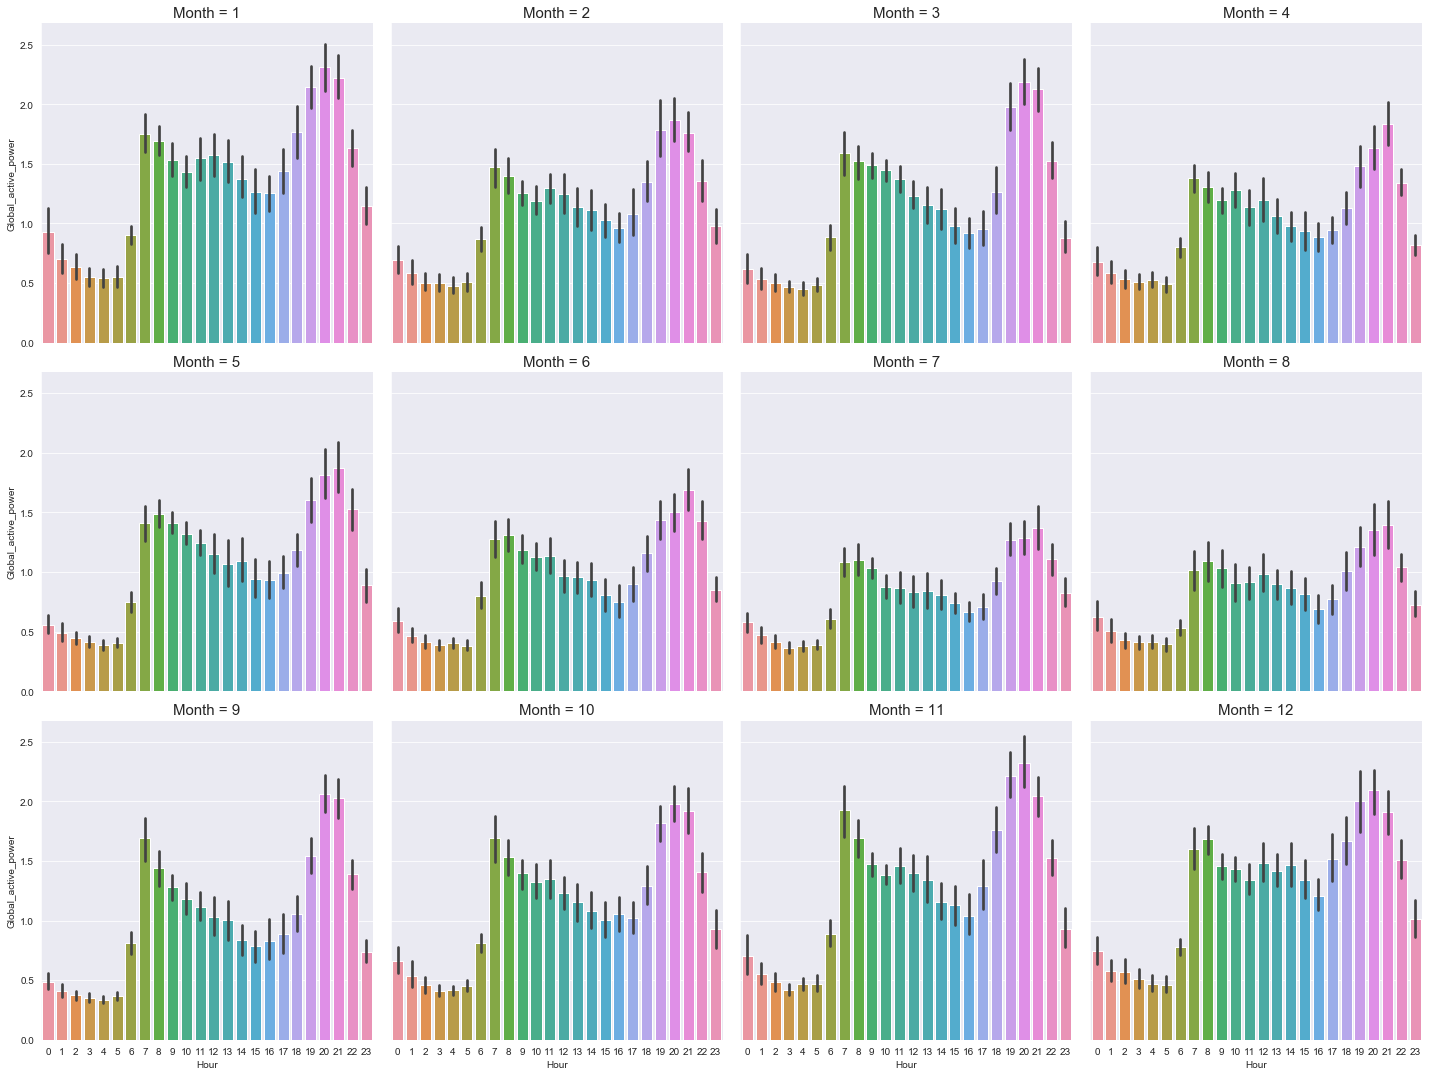

In [21]:
current_palette = sns.color_palette("Paired")

hour_plot2 = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Month",
           col_wrap = 4)
hour_plot2.set_titles(size = 15)

### Visualization

Now that we have a good idea of time series trends for Global_active_power, the visualization below shows a comprehensive view of the dataset. The plotly visual shows mean, median, and peak power values for all dates in the time series. There are options to filter or adjust by time period and to select the metric of interest (mean, median, peak, or all three).

In [22]:
energy.Date = pd.to_datetime(energy['Date'])
energy_daily_summary = energy.groupby('Date', 
                                      as_index=False).agg(
    {'Global_active_power':{'mean_active_power': 'mean',
                            'median_active_power': 'median',
                            'max_active_power': 'max'}})
mean_power = go.Scatter(x=energy_daily_summary.Date,
                        y=energy_daily_summary.Global_active_power.mean_active_power,
                        name='mean_power',
                        line=dict(color='red'))

median_power = go.Scatter(x=energy_daily_summary.Date,
                            y=energy_daily_summary.Global_active_power.median_active_power,
                            name='median_power',
                            line=dict(color='blue'))

max_power = go.Scatter(x=energy_daily_summary.Date,
                       y=energy_daily_summary.Global_active_power.max_active_power,
                       name='max_power',
                       line=dict(color='green'))

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Mean',
                 method = 'update',
                 args = [{'visible': [True, False, False]},
                         {'title': 'Mean Global Active Power'}]),
                         
            dict(label = 'Median',
                 method = 'update',
                 args = [{'visible': [False, True, False]},
                         {'title': 'Median Global Active Power'}]),
                         
            dict(label = 'Maximum',
                 method = 'update',
                 args = [{'visible': [False, False, True]},
                         {'title': 'Maximum Global Active Power'}]),
            dict(label = 'All',
                 method = 'update',
                 args = [{'visible': [True, True, True]},
                         {'title': 'Overview of Global Active Power'}]),              
        ]),
    )
])

data = [mean_power, median_power, max_power]

layout = dict(title='Daily Global Active Power', 
              showlegend=True, 
              updatemenus = updatemenus,
              legend=dict(orientation="h"),
              xaxis = dict(
                  rangeselector=dict(
                      buttons=list([
                          dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                          dict(count=6,
                             label='6m',
                             step='month',
                             stepmode='backward'),
                          dict(count=1,
                            label='1y',
                            step='year',
                            stepmode='todate'),
                          dict(count=2,
                            label='2y',
                            step='year',
                            stepmode='backward'),
                          dict(step='all')
                      ]))))

plot = dict(data=data, layout=layout)
py.plotly.iplot(plot, filename='household_power_consumption')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mkivenson/0 or inside your plot.ly account where it is named 'household_power_consumption'


## Pre-Process Data

Since we performed some data clean-up after importing the Household Power Consumption Dataset, the pre-processing step is limited. The code chunk below creates an hourly summary of mean power and then encodes 'Year' as categorical data using the Label Encoder. 

In [23]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])
energy_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


## Time Series Forecasting

### Forecasting with Linear Regression

To get started with time series forecasting, we create a linear regression forecast. This is not an effective model, since it does not account for seasonal variation in a time series.

#### Partition Series

The series are partitioned randomly with a 75% - 25% split between the train set and test set, respectively.

In [24]:
from sklearn.model_selection import train_test_split
x = energy_hourly_summary[['Year','Month','Day','Hour']]
y = energy_hourly_summary.Global_active_power
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

#### Apply Forecasting Methods

The linear regression method below uses the linear relationship between the x and y components of the training set to predict the y component of the test set.

In [25]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)

#### Evaluate Performance
The scatter plot below shows the relationship between the actual test values and the predicted test values. It is evident from the equation of the regression line and the r-squared value that this is not a good model for the Global_active_power time series.

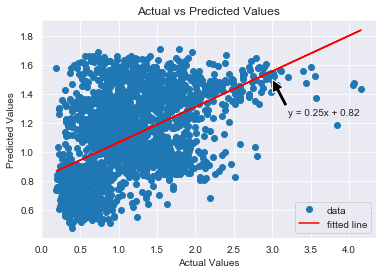

r-squared: 0.259503


In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.annotate(
'y = ' + str(round(slope,2)) + 'x' + ' + ' + str(round(intercept,2)), xy=(3, 1.5), xytext=(3.2, 1.25),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.xlabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Predicted Values')
plt.show()
print("r-squared: %f" % r_value**2)

### Forecasting with SARIMAX

Seasonal AutoRegressive Integrated Moving Average (SARIMAX) is ideal for forecasting univariate time series data containing seasonal trends.

#### Partition Series

The series are partitioned based on year, with 2006-2009 in the train set and 2010 in the test set.

In [28]:
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

#### Apply Forecasting Methods

For this model, we apply SARIMA on a weekly summary of the Global_active_power. I attempted to use days, however the processing time was too long.

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
train_monthly=train[['Global_active_power']].resample('W').mean()
mod = SARIMAX(train_monthly, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 50), #50 = number of weeks that we are forcasting
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [30]:
results.forecast()

2010-01-10    1.02102
Freq: W-SUN, dtype: float64

To extract forecasts, we indicate the date range that we are forecasting (most of 2010) in the .predict function below. The start and end indices of this function require exact values that are based on the seasonal_order specified in the SARIMA function.

In [84]:
predictions = results.predict(start='2010-01-03', end='2010-12-19')

#### Evaluate Performance

To evaluate the performance of the SARIMA model, we plot the distributions of predicted versus actual weekly power values in 2010. It seems like the distributions share a similar center but there are noticible differences in the shapes of the distributions.

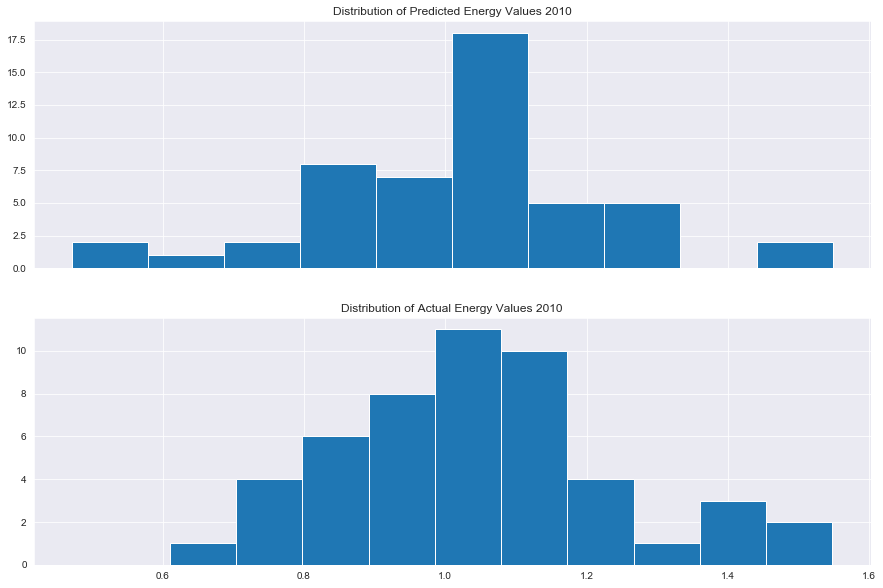

In [32]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(predictions.values, bins=10)
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test[['Global_active_power']].resample('W').mean().values), bins=10)
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

**Actual versus Predicted Values**

The next visualization is much more telling, as it compares the actual test values and the predicted test values. It is clear that the prediction of Global_Active_Power captures the seasonal changes present in the actual data. First, we combine the actual and predicted values for each week into one dataframe.

In [131]:
#merge on Date_Time
test[['Global_active_power']].resample('W').mean().reset_index()
prediction = pd.DataFrame(predictions).reset_index()
prediction.columns = ['Date_Time','Global_active_power']

res = pd.merge(test[['Global_active_power']].resample('W').mean(), 
               prediction, 
               how='left', 
               on='Date_Time')

res.columns = ['Date_Time','actual','predictions']
res.insert(3, 'residuals', res['actual'] - res['predictions']) #residuals
res.head()

MSE =  0.05315903905285634


,Date_Time,actual,predictions,residuals
0,2010-01-03,0.976101,1.512261,-0.536160
1,2010-01-10,0.920572,1.021020,-0.100448
2,2010-01-17,1.451530,1.305795,0.145734
3,2010-01-24,1.535291,1.039394,0.495898
4,2010-01-31,1.548028,0.853604,0.694425


Upon looking at the plot of actual versus predicted weekly Global_active_power, we see that the SARIMA predictions were close to the actual values. The plot of residuals shows that the difference between actuals and predicted values may have a pattern: mostly positive residuals in the first half of 2010, and mostly negative residuals in the latter half of 2010. Using the residuals, we calculate a Mean Squared Error (MSE) of 0.0532.

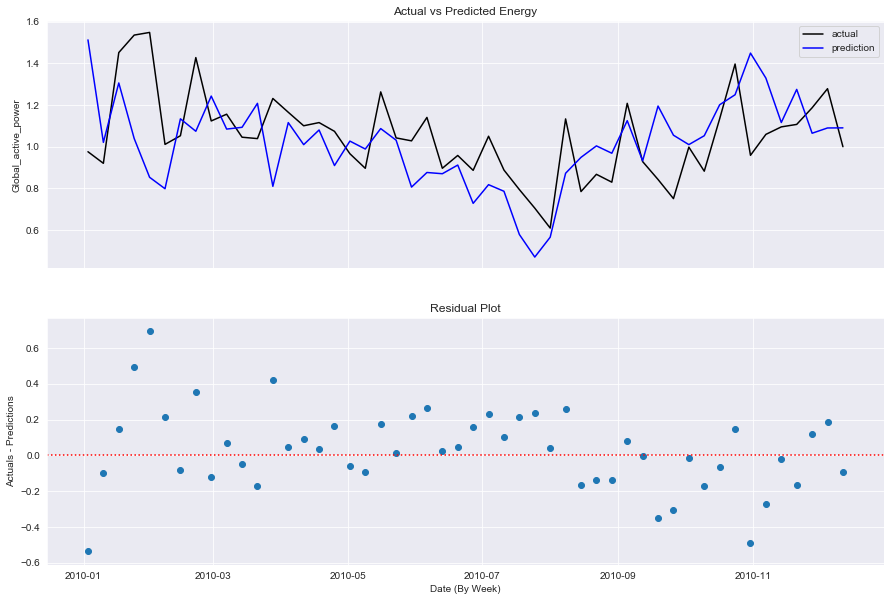

MSE =  0.05315903905285634


In [140]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(res['Date_Time'],res['actual'], color='black', label='actual')
axes[0].plot(res['Date_Time'],res['predictions'], color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(res['Date_Time'],(res['actual'] - res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Date (By Week)')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res['residuals']**2)) #MSE

### Forecasting with Prophet
Prophet is a forecasting method created by Facebook that is used for seasonal time series. Rather than supplying weekly power averages, we can train this model using daily power averages.

#### Partition Series
This step creates the train and test datasets, each containing a date and the mean Global_active_power for that date. Similarly to the SARIMA model, I partitioned the train / test datasets by year.

In [34]:
train_2 = train.resample('D').mean().reset_index()
train_2 = train_2[['Date_Time', 'Global_active_power']]
train_2.columns = ['ds', 'y']
train_2.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [35]:
test_2 = test.resample('D').mean().reset_index()
test_2 = test_2[['Date_Time', 'Global_active_power']]
test_2.columns = ['ds', 'y']
test_2.head()

,ds,y
0,2010-01-01,0.850175
1,2010-01-02,1.176235
2,2010-01-03,0.901894
3,2010-01-04,1.171833
4,2010-01-05,0.916776


#### Apply Forecasting Methods

This step creates trains the Prophet model; the fourier_order argument specifies how closely we want to capture the seasonality of the time series. A fourier_order of 10 translates to annual seasonality while a fourier_order of 3 translates to weekly seasonality. To avoid under- or over-fitting, I used a fourier_order of 8.

In [36]:
ph = Prophet(weekly_seasonality=False)
ph.add_seasonality(name='daily', period=1, fourier_order=8)
ph.fit(train_2)

INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


This step creates a forecast for the next 365 days. The yhat_lower and yhat_upper values correspond to the default 80% confidence interval.

In [101]:
future = ph.make_future_dataframe(periods=365)
forecast = ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2006-12-16,1.476000,0.964014,1.992990
1,2006-12-17,1.485828,0.993611,1.973745
2,2006-12-18,1.495810,1.001226,1.993640
3,2006-12-19,1.505690,1.044064,2.050115
4,2006-12-20,1.515212,1.041128,2.016229


#### Evaluate Performance

To evaluate this model, we plot the Prophet prediction against the actual Global_active_power values for the entire time series. The actual values are plotted as points while the forecast is plotted as a line; the section with green points corresponds to the test set. It seems like the Prophet forecast model performed faily well, capturing the seasonal trends for the consumption time series. 

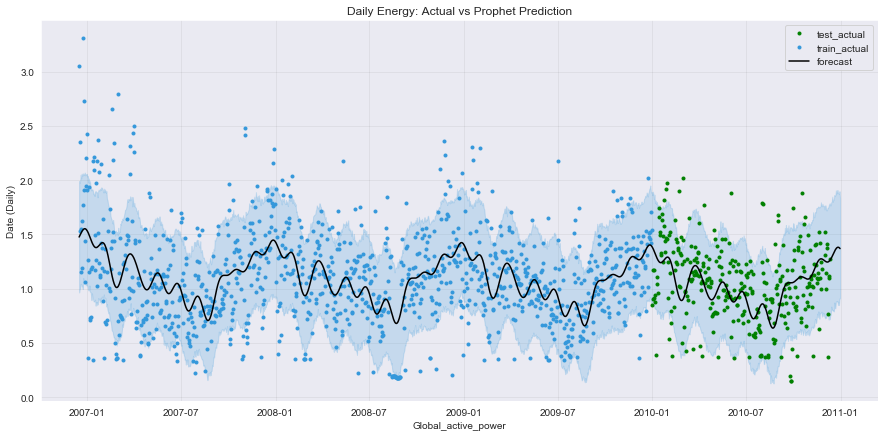

In [127]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_2.ds, test_2.y, '.', color='green', label = "test_actual")
plt.plot(train_2.ds, train_2.y, '.', color='#3498db', label = "train_actual")
plt.plot(forecast.ds, forecast.yhat, color='black', label = "forecast")
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

**Residuals**

It would now be helpful to merge the two datasets in order to compare actuals and forecasted value. The table below gives a preview of this information.

In [138]:
#merge on Date_Time
res2 = pd.merge(test_2, 
               forecast[['ds','yhat']], 
               how='left', 
               on='ds')
res2.columns = ['Date_Time','actual','predictions']
res2.insert(3, 'residuals', res2['actual'] - res2['predictions']) #residuals
res2.head()

MSE =  0.05315903905285634


,Date_Time,actual,predictions,residuals
0,2010-01-01,0.850175,1.381252,-0.531077
1,2010-01-02,1.176235,1.372271,-0.196036
2,2010-01-03,0.901894,1.362131,-0.460236
3,2010-01-04,1.171833,1.351065,-0.179232
4,2010-01-05,0.916776,1.339331,-0.422554


The plot of residuals (actual - predicted values) shows constant variability across all dates in 2010. Using the residuals, we also calculate a Mean Squared Error (MSE) of 0.118.

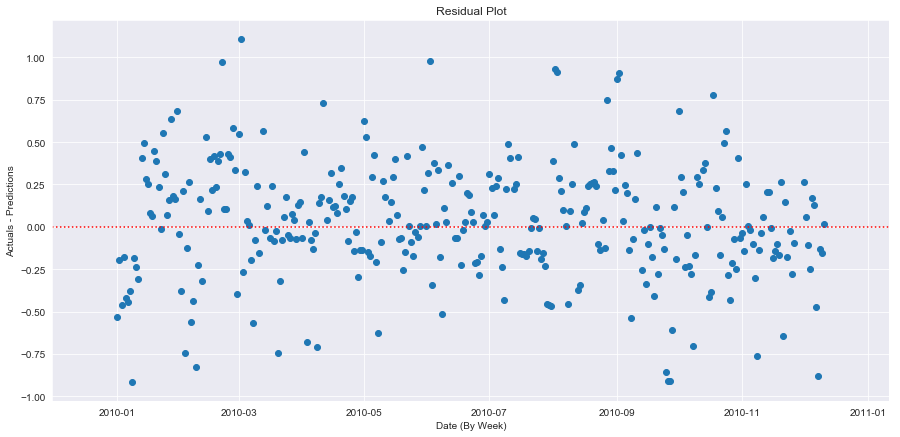

MSE =  0.11787680156490757


In [139]:
fig = plt.gcf()
fig.set_size_inches(15, 7)

#plot of residuals
plt.scatter(res2['Date_Time'],(res2['residuals']))
plt.title('Residual Plot')
plt.xlabel('Date (By Week)')
plt.ylabel('Actuals - Predictions')
plt.axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res2['residuals']**2)) #MSE

## Conclusion

The approach of visualizing and forecasting the power consumption dataset resulted in finding two useful models for this application: SARIMA and Prophet. Visualizing the data reveals the seasonal trends that exist in power consumption, which in turn helped in selecting time series forecasting models that are sensitive to seasonality.

## Sources

[Linear Regression](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)

[SARIMA](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

[Prophet](https://facebook.github.io/prophet/)